In [1]:
from IPython.display import HTML
HTML('''<script>
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
    $('div.output_prompt').hide()
  });
</script>''')

# Performance Data Comparison

This notebook can be used to compare summaries of two sets of performance benchmark data.


In [1]:
compareDatasets = True

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

matplotlib.rcParams['figure.figsize'] = 9, 6
matplotlib.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['figure.dpi'] = 120

# We'll need these packages for plotting fit lines
import statsmodels.api as sm
from patsy import dmatrices

from io import StringIO
import re

import os.path
assert os.path.isfile('cpuStats.csv'), 'Missing CPU stats file "cpuStats.csv"'
assert os.path.isfile('perfResults.csv'), 'Missing performance results file "perfResults.csv"'

if compareDatasets:
    assert os.path.isfile('old_cpuStats.csv'), 'Missing old CPU stats file "old_cpuStats.csv"'
    assert os.path.isfile('old_perfResults.csv'), 'Missing old performance results file "old_perfResults.csv"'

## CPU Percentage over time

We are curretly sampling the CPU percentage data at `5s`.

In [3]:
resampleFrequency = 5

In [4]:
def processCpuData(data):
    meanData = data.resample('{0}s'.format(resampleFrequency)).mean()
    meanData = meanData.reset_index()
    meanData = meanData.set_index(meanData.index.values * resampleFrequency)
    return meanData

cpuData = pd.read_csv('cpuStats.csv', parse_dates=['timestamp'], index_col=['timestamp'])
cpuMeanData = processCpuData(cpuData)

if compareDatasets:
    oldCpuData = pd.read_csv('old_cpuStats.csv', parse_dates=['timestamp'], index_col=['timestamp'])
    oldCpuMeanData = processCpuData(oldCpuData) 

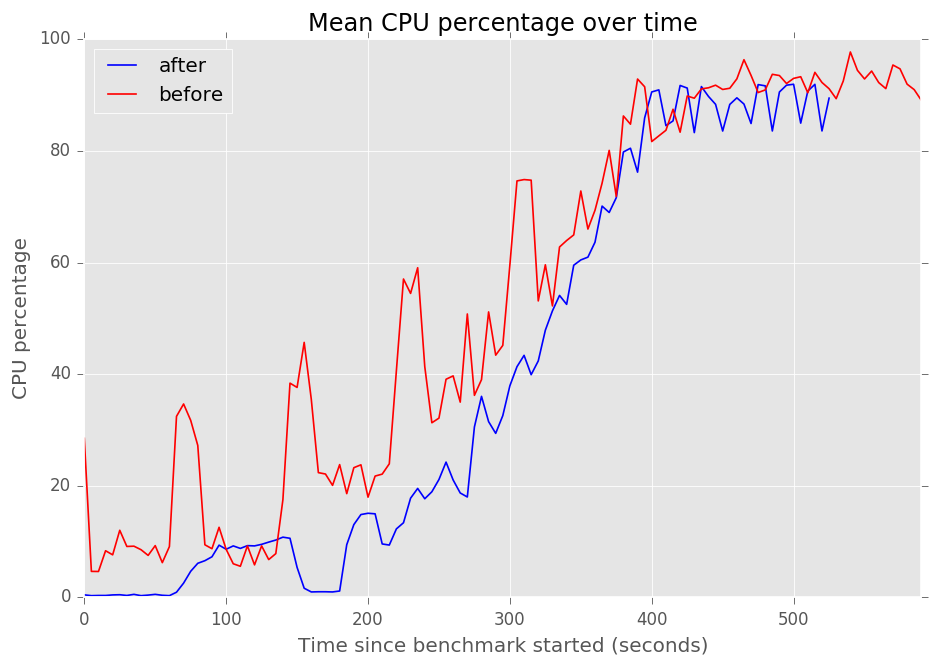

In [5]:
fig, ax = plt.subplots()
ax = cpuMeanData.plot(ax=ax, y='percentage', c='b')
if compareDatasets:
    ax = oldCpuMeanData.plot(ax=ax, y='percentage', c='r')
    ax.legend(['after', 'before'])
else:
    ax.legend(['mean'])
ax.set_ylabel('CPU percentage')
ax.set_xlabel('Time since benchmark started (seconds)')
ax.set_title('Mean CPU percentage over time')
plt.show()

## Throughput Data over time


In [6]:
def readThroughputData(filename):
    with open(filename) as f:
        data = f.read()
    # Get locations of start-time,response-time headers in file
    header_idxs = [m.start() for m in re.finditer('start-time,response-time', data)]
    header_idxs.append(len(data))
    prev = header_idxs[0]
    
    df = pd.DataFrame()
    # Read each section delimited by the csv headers
    for cur in header_idxs[1:]:
        dfSection = pd.read_csv(StringIO(data[prev:cur]), parse_dates=['start-time'])
        df = df.append(trimEdges(dfSection))
        prev = cur
    # Reset the index because it is a Frankenstein of smaller indexes
    df = df.reset_index().drop('index', axis=1)
    return df
    
def trimEdges(data):
    indexes = data.set_index('start-time').resample('1S').aggregate(lambda x: 1).index
    testStartTime = indexes[1]
    testEndTime = indexes[-2]
    return data[(data['start-time'] >= testStartTime) & (data['start-time'] <= testEndTime)]
    
def processThroughputData(data):
    buckets = data.set_index('start-time')['response-time'].resample('1S')
    throughputData = buckets.aggregate({'throughput': lambda x: np.nan if x.count() == 0 else x.count()})
    throughputData = throughputData.reset_index()
    throughputData = throughputData.fillna(method='ffill')
    return buckets, throughputData
    
goData = readThroughputData('perfResults.csv')
throughputBuckets, throughputData = processThroughputData(goData)

if compareDatasets:
    oldGoData = readThroughputData('old_perfResults.csv')
    oldThroughputBuckets, oldThroughputData = processThroughputData(oldGoData)

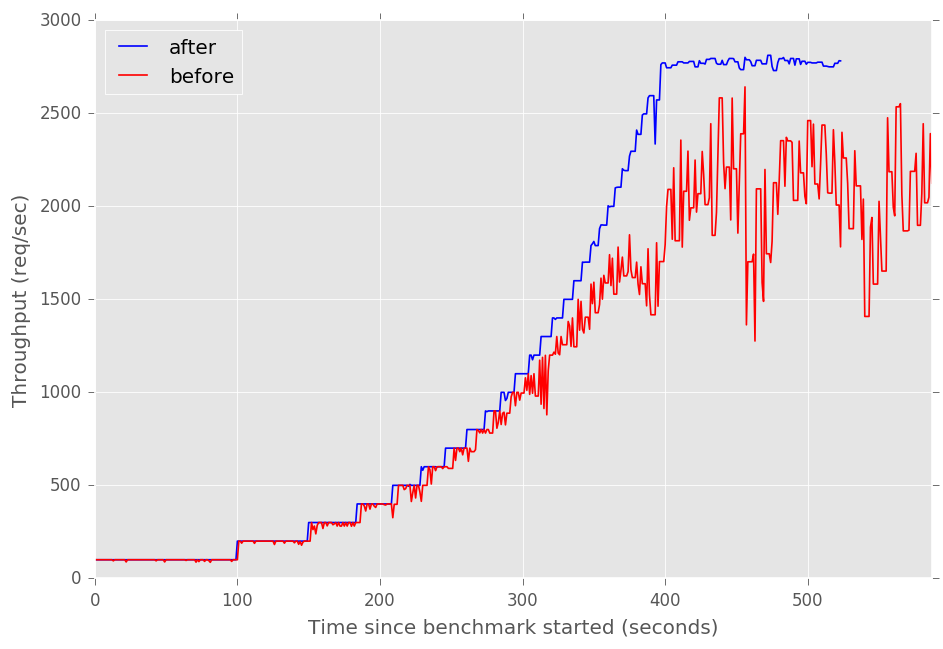

In [7]:
fix, ax = plt.subplots()
ax = throughputData.plot(ax=ax, y='throughput', c='b')
if compareDatasets:
    ax = oldThroughputData.plot(ax=ax, y='throughput', c='r')
    ax.legend(['after', 'before'])
ax.set_ylabel('Throughput (req/sec)')
ax.set_xlabel('Time since benchmark started (seconds)')
plt.show()

## Headroom plot

In [8]:
goData['throughput'] = throughputBuckets.transform(len).reset_index()['response-time']
goData.columns = ['start-time', 'latency', 'throughput']

if compareDatasets:
    oldGoData['throughput'] = oldThroughputBuckets.transform(len).reset_index()['response-time']
    oldGoData.columns = ['start-time', 'latency', 'throughput']

In [9]:
def generateFitLine(data):
    y, x = dmatrices('latency ~ throughput', data=data, return_type='dataframe')
    fit = sm.GLM(y, x, family=sm.families.InverseGaussian(sm.families.links.inverse_squared)).fit()

    domain = np.arange(data['throughput'].min(), data['throughput'].max())
    predictionInputs = np.ones((len(domain), 2))
    predictionInputs[:,1] = domain
    fitLine = fit.predict(predictionInputs)
    return domain, fitLine

domain, goFitLine = generateFitLine(goData)

if compareDatasets:
    oldDomain, oldGoFitLine = generateFitLine(oldGoData)

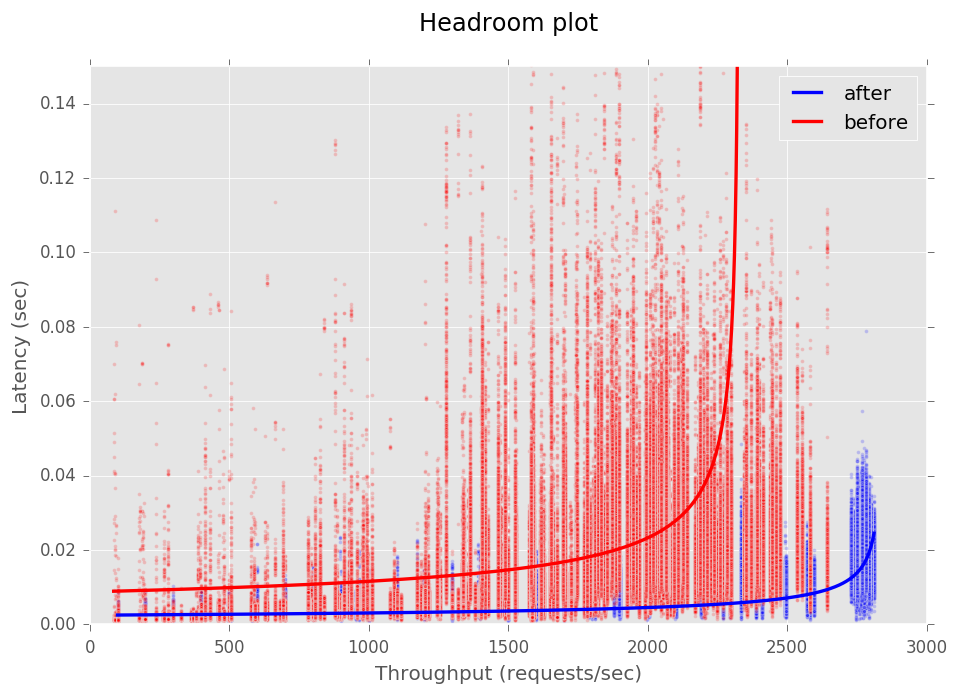

In [10]:
fig, ax = plt.subplots()

# Change the value of `c` to change the color. http://matplotlib.org/api/colors_api.html
ax = goData.plot(ax=ax, kind='scatter', x='throughput', y='latency', c='b', marker='.', alpha=0.2)
ax.plot(domain, goFitLine, c='b', lw=2) # Plot the fit line

if compareDatasets:
    ax = oldGoData.plot(ax=ax, kind='scatter', x='throughput', y='latency', c='r', marker='.', alpha=0.2)
    ax.plot(oldDomain, oldGoFitLine, c='r', lw=2) # Plot the fit line
    ax.legend(['after', 'before'])

# To update x & y axis range change the parameters in function set_(x/y)lim(lower_limit, uppper_limit) 
ax.set_ylim(0,0.15)
ax.set_xlim(0,3000)
plt.xlabel('Throughput (requests/sec)')
plt.ylabel('Latency (sec)')
plt.title('Headroom plot', y=1.05)
plt.show()